<a href="https://colab.research.google.com/github/revak18/nicotine_use_mathmodel/blob/main/NicotineUse_SIR_DDE_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First DRAFT

In [ ]:
!pip install ddeint

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ddeint import ddeint

# Constants
B = 0.00103  # Birth rate per month
mu = 0.0006254  # Death rate per month
aging_rate_y_to_ya = 1 / (7 * 12) # 7 years to transition from 'youth' (11yrs) to 'young adult' (18yrs)
aging_rate_ya_to_a = 1 / (5 * 12)  # 5 years to transition from 'young adult' (18yrs)  to 'adult' (23yrs)


# tau_1: Delay for Infection (12 months)
tau_1 = 12
# Justification: The delay for infection (tau_1 = 12 months) reflects the time it might take for susceptible individuals
# to initiate Nicotine use. This delay can account for the gradual exposure to influencing factors like peer pressure,
# marketing, and social trends, which do not immediately result in uptake but may do so over an extended period.
# A year-long delay allows for these influences to accumulate and reflect realistic patterns seen in epidemiological studies
# of behavior adoption where repeated exposures increase the likelihood of adoption.

# tau_2:  Delay for Recovery (6 months)
tau_2 = 6
# How Long Does it Take to Break a Nicotine Addiction?
# https://www.urbanrecovery.com/blog/how-long-does-it-take-to-break-a-nicotine-addiction
# The recovery delay (tau_2 = 6 months) represents the time it might take for an individual to cease using nicotine products.
# Weeks 1-2	Physical withdrawal: During this period, the body adjusts to the absence of nicotine. Withdrawal symptoms are typically at their peak.

# Weeks 3-4	Psychological adjustments: As the physical withdrawal symptoms subside, individuals may still experience psychological cravings and triggers.
# This period focuses on addressing the psychological aspects of addiction.

# Months 1-6	Consolidating recovery: The cravings become less frequent and intense during this period. Individuals continue to refine coping strategies
# and adjust to life without nicotine.

# Beyond 6 Months	Maintaining a smoke-free life: After six months, many individuals experience a significant reduction in cravings and a sense of freedom
# from nicotine addiction. However, it's important to remain vigilant and continue implementing healthy habits to prevent relapse.


# tau_3: Delay for Relapse (12 months)
tau_3 = 12
# Stages of Change Theory: https://www.ncbi.nlm.nih.gov/books/NBK556005/
# "A longitudinal study from the 1990 Surgeon General's Report showed that after 12 months of abstinence, 43% of people returned to their smoking habit."

In [ ]:
import numpy as np
import random

#########################################
# beta: Infection coefficient
#########################################
# "If one of your best friends offered you a cigarette, would you smoke it?"
#  For e-cigarettes, 18% responded "yes" - 2016 U.S. Surgeon General report
#  For cigarettes, 0.3% responded "yes" - 2014 National Survey on Drug Use and Health
#  Calculates beta using "18%" & flg="EC"(e-cigarettes) OR 3% & flg="C"(cigarettes) as seed and seasonal variation.

def beta(t, flg):
  if flg == 'EC':
     beta = 0.18 + (random.random()/100) * np.cos(t / 12 * np.pi)
  else:
     beta = 0.003 + (random.random()/1000) * np.cos(t / 12 * np.pi)
  return beta


#########################################
# gamma: Recovery coefficients
#########################################
# Smoking Cessation: Fast Facts
# https://www.cdc.gov/tobacco/php/data-statistics/smoking-cessation/index.html
# In 2022, 67.7% of adults who smoked said they wanted to quit smoking.

# Quitting e-cigarettes: Quit attempts and quit intentions among youth and young adults
# https://pmc.ncbi.nlm.nih.gov/articles/PMC7808959/#:~:text=3.2.-,Cessation%20outcomes,reported%20general%20intentions%20to%20quit.
# Among current e-cigarette users, 33.3% reported a past-year quit attempt

# Calculates gamma using "33.30%" & flg="EC"(e-cigarettes) OR 67.70% & flg="C"(cigarettes) as seed and seasonal variation.
def gamma(t, flg):
  if flg == 'EC':
     gamma = (1.333 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #e-cigarettes
  else:
     gamma = (1.677 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #cigarettes
  return gamma


#########################################
# rho: Relapse coefficients
#########################################
# Smoking Cessation: Fast Facts
# https://www.cdc.gov/tobacco/php/data-statistics/smoking-cessation/index.html
# In 2022, 8.8% of adults who smoked were able to successfully quit smoking in the past year.
# That means 100 - 8.8 = 91.2% relapsed.

# Effectiveness of e-cigarettes as aids for smoking cessation: evidence from the PATH Study cohort, 2017–2019
# https://tobaccocontrol.bmj.com/content/32/e2/e145
# Furthermore, switching to e-cigarettes did not reduce the risk of relapse to cigarette smoking compared with other recent former smokers.
# Instead, nearly 60% of recent former smokers who were daily e-cigarette users had relapsed to cigarette smoking by 2019 (W5).

# Calculates rho using "60.00%" & flg="EC"(e-cigarettes) OR 91.20% & flg="C"(cigarettes) as seed and seasonal variation.
def rho(t, flg):
  if flg == 'EC':
     rho = (1.600 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #e-cigarettes
  else:
     rho = (1.912 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #cigarettes
  return rho

In [ ]:
def model(Y, t):

    S_y, I_y, R_y, S_ya, I_ya, R_ya, S_a, I_a, R_a = Y(t)

    # Accessing delayed values using indexing
    if t >= tau_1:
        S_y_delay = Y(t - tau_1)[0]
        I_y_delay = Y(t - tau_1)[1]
        R_y_delay = Y(t - tau_1)[2]
    else:
        S_y_delay, I_y_delay, R_y_delay = S_y, I_y, R_y

    if t >= tau_2:
        I_y_delay2 = Y(t - tau_2)[1]
    else:
        I_y_delay2 = I_y

    if t >= tau_3:
        R_y_delay3 = Y(t - tau_3)[2]
    else:
        R_y_delay3 = R_y

    t = int(t)

    # Population dynamics
    dS_y_dt = B - beta[t] * S_y * I_y_delay - mu * S_y - aging_rate_y_to_ya * S_y
    dI_y_dt = beta[t] * S_y * I_y_delay - (mu + gamma[t]) * I_y_delay2 + rho[t] * R_y_delay3 - aging_rate_y_to_ya * I_y
    dR_y_dt = gamma[t] * I_y_delay2 - (mu + rho[t]) * R_y - aging_rate_y_to_ya * R_y

    dS_ya_dt = S_y * aging_rate_y_to_ya - beta[t] * S_ya * I_ya - mu * S_ya - aging_rate_ya_to_a * S_ya
    dI_ya_dt = I_y * aging_rate_y_to_ya + beta[t]* S_ya * I_ya - (mu + gamma[t]) * I_ya - aging_rate_ya_to_a * I_ya
    dR_ya_dt = R_y * aging_rate_y_to_ya + gamma[t] * I_ya - (mu + rho[t]) * R_ya - aging_rate_ya_to_a * R_ya

    dS_a_dt = S_ya * aging_rate_ya_to_a - beta[t] * S_a * I_a - mu * S_a
    dI_a_dt = I_ya * aging_rate_ya_to_a + beta[t] * S_a * I_a - (mu + gamma[t]) * I_a
    dR_a_dt = R_ya * aging_rate_ya_to_a + gamma[t] * I_a - (mu + rho[t]) * R_a

    return [dS_y_dt, dI_y_dt, dR_y_dt, dS_ya_dt, dI_ya_dt, dR_ya_dt, dS_a_dt, dI_a_dt, dR_a_dt]

def history(t):
    if product_type == 'EC':    # E-Cigarettes
       return [0.8000, 0.2000, 0.0000, 0.9400, 0.0600, 0.0000, 0.9400, 0.0600, 0.0000]  # Initial values for E-cigarettes all states of Youth, Young Adults and Adults as of 2022
    else:    # Cigarettes
       return [0.9170, 0.0830, 0.0000, 0.8840, 0.1160, 0.0000, 0.8840, 0.1160, 0.0000]  # Initial values for Cigarettes all states of Youth, Young Adults and Adults as of 2022

# Solve DDE
t = np.linspace(0, 120, 120)  # Simulate for 10 years
t = t.astype('int32')
sol = ddeint(model, history, t)

totals = sol.sum(axis=1)
sol /= totals[:, None]

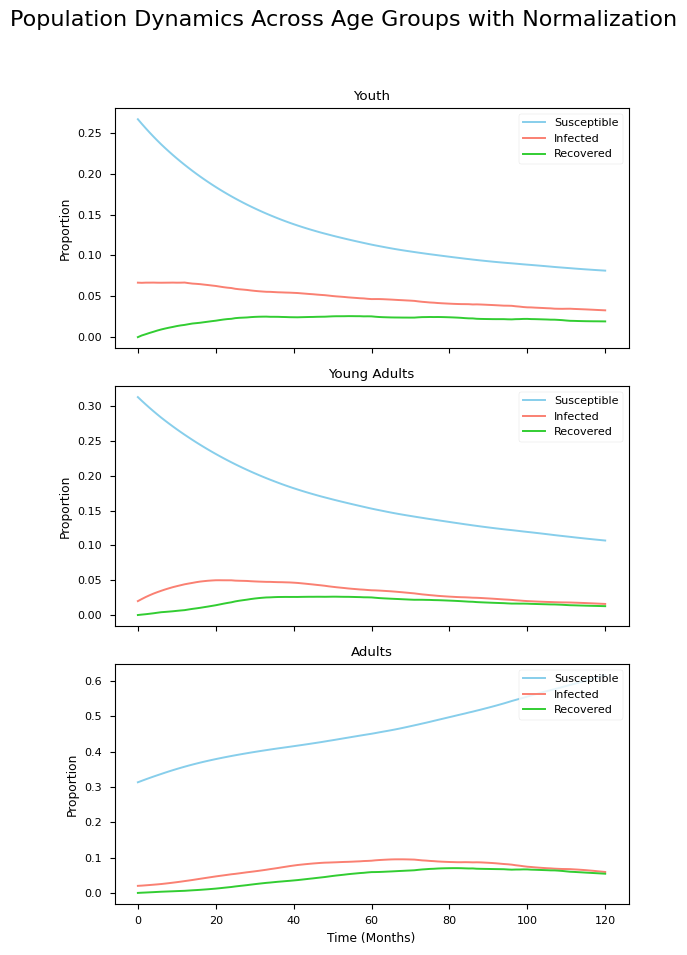

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 't' and 'sol' are defined as per your model output
# Example data (uncomment and modify according to your actual 't' and 'sol' variables)
# t = np.linspace(0, 120, 120)
# sol = np.random.rand(120, 9)  # Simulated solution for demonstration

# Use a built-in style
plt.style.use('seaborn-v0_8-paper')  # or 'ggplot', 'seaborn-poster', etc., based on preference

#['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background',
#'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind',
#'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook',
#'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


# Set up figure and axes
fig, axs = plt.subplots(3, 1, figsize=(6, 10), sharex=True)  # Share X-axis

# Titles for each subplot
titles = ['Youth', 'Young Adults', 'Adults']
labels = ['Susceptible', 'Infected', 'Recovered']
colors = ['skyblue', 'salmon', 'limegreen']  # Colors for each line

for i in range(3):
    ax = axs[i]
    for j in range(3):
        ax.plot(t, sol[:, i*3 + j], label=labels[j], color=colors[j])
    ax.set_title(titles[i])
    ax.set_ylabel('Proportion')
    ax.legend(frameon=True, loc='upper right')
    if i == 2:
        ax.set_xlabel('Time (Months)')

fig.suptitle('Population Dynamics Across Age Groups with Normalization', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to leave space for suptitle

plt.show()


Predicted Population Counts (in millions):
   Year  Youth Susceptible  Youth Infected  Youth Recovered  \
0  2022               8.56            0.77             0.00   
1  2023               7.60            0.56             0.17   
2  2024               6.79            0.46             0.16   
3  2025               6.19            0.46             0.14   
4  2026               5.56            0.44             0.14   

   Young Adults Susceptible  Young Adults Infected  Young Adults Recovered  \
0                      8.84                   1.16                    0.00   
1                      8.44                   0.63                    0.25   
2                      8.01                   0.37                    0.25   
3                      7.69                   0.24                   -0.06   
4                      7.20                   0.18                   -0.07   

   Adults Susceptible  Adults Infected  Adults Recovered  
0               68.36             8.97            

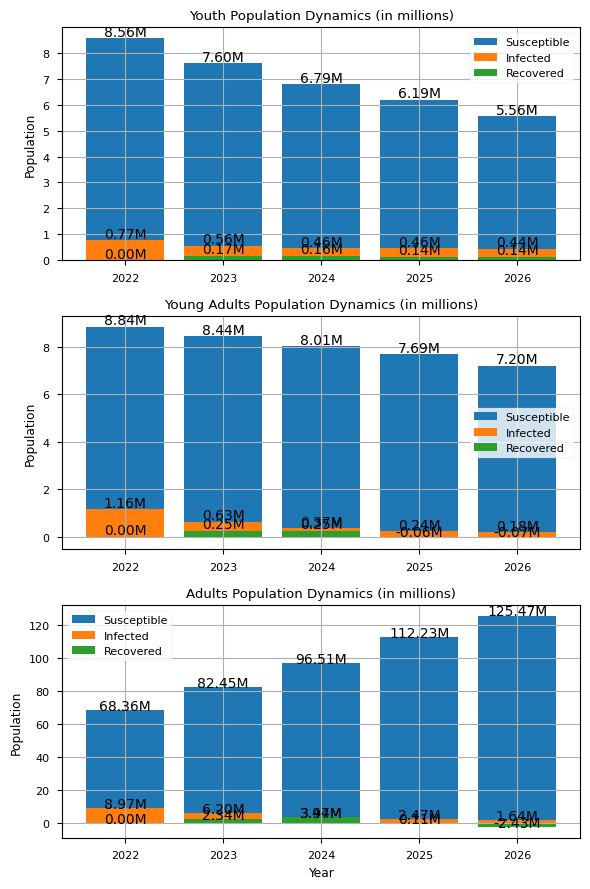

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming sol contains normalized proportions and population data is given
# Base population for each group (in millions)
population_youth = 28  # Replace with actual values
population_young_adults = 30  # Replace with actual values
population_adults = 232  # Replace with actual values

years = [2022, 2023, 2024, 2025, 2026]
time_indices = [(year - 2022) * 12 for year in years]

data = []
for idx, year in zip(time_indices, years):
    youth_counts = sol[idx, :3] * population_youth
    young_adults_counts = sol[idx, 3:6] * population_young_adults
    adults_counts = sol[idx, 6:9] * population_adults

    data.append([
        year,
        *youth_counts,
        *young_adults_counts,
        *adults_counts
    ])

columns = [
    "Year",
    "Youth Susceptible", "Youth Infected", "Youth Recovered",
    "Young Adults Susceptible", "Young Adults Infected", "Young Adults Recovered",
    "Adults Susceptible", "Adults Infected", "Adults Recovered"
]

df = pd.DataFrame(data, columns=columns)

# Display the table
df = df.round(2)
print("Predicted Population Counts (in millions):")
print(df)

# Plotting bar charts for each age group
categories = ["Susceptible", "Infected", "Recovered"]
fig, axes = plt.subplots(3, 1, figsize=(6, 9))

# Plot for Youth
for i, cat in enumerate(categories):
    axes[0].bar(
        years,
        df[[f"Youth {cat}" for cat in categories]].iloc[:, i],
        label=cat
    )
    for year, value in zip(years, df[f"Youth {cat}"].values):
        axes[0].text(year, value + 0.1, f"{value:.2f}M", ha="center")
axes[0].set_title("Youth Population Dynamics (in millions)")
axes[0].legend()
axes[0].set_ylabel("Population")
axes[0].grid(True)

# Plot for Young Adults
for i, cat in enumerate(categories):
    axes[1].bar(
        years,
        df[[f"Young Adults {cat}" for cat in categories]].iloc[:, i],
        label=cat
    )
    for year, value in zip(years, df[f"Young Adults {cat}"].values):
        axes[1].text(year, value + 0.1, f"{value:.2f}M", ha="center")
axes[1].set_title("Young Adults Population Dynamics (in millions)")
axes[1].legend()
axes[1].set_ylabel("Population")
axes[1].grid(True)

# Plot for Adults
for i, cat in enumerate(categories):
    axes[2].bar(
        years,
        df[[f"Adults {cat}" for cat in categories]].iloc[:, i],
        label=cat
    )
    for year, value in zip(years, df[f"Adults {cat}"].values):
        axes[2].text(year, value + 0.1, f"{value:.2f}M", ha="center")
axes[2].set_title("Adults Population Dynamics (in millions)")
axes[2].legend()
axes[2].set_ylabel("Population")
axes[2].set_xlabel("Year")
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
def beta_values(t):
    """Calculate beta values with exponential decay and seasonal variation."""
    if product_type == 'EC':
        beta_0 = 0.18  # Initial infection coefficient for e-cigarettes
        k = 0.25       # Decay constant for e-cigarettes
        seasonal_amplitude = 0.005  # Small seasonal variation amplitude
    else:
        beta_0 = 0.003  # Initial infection coefficient for cigarettes
        k = 0.05        # Decay constant for cigarettes
        seasonal_amplitude = 0.0001  # Small seasonal variation amplitude

    # Base beta value with exponential decay
    beta_base = beta_0 * np.exp(-k * t / 12)  # Time in years

    # Add seasonal variation (sinusoidal component with amplitude)
    beta_seasonal = seasonal_amplitude * np.cos(t / 12 * np.pi)  # Periodic variation (yearly cycle)
    return beta_base + beta_seasonal



# Function to calculate gamma values - Recovery
def gamma_values(t):
    """Calculate gamma values depending on the product type."""
    if product_type == 'EC':
        #return (1.333 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)
        base_gamma = 0.0450  # Annual recovery constant
    else:
        #return (1.677 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)
        base_gamma = 0.0921  # Annual recovery constant

    monthly_gamma = (1 - np.exp(-base_gamma / 12))  # Convert annual to monthly recovery rate
    seasonal_variation = (random.random() / 100) * np.cos(t / 12 * np.pi)  # Add seasonal variability
    return monthly_gamma + seasonal_variation



# Function to calculate rho values - Relapse
def rho_values(t):
    """Calculate rho values depending on the product type."""
    if product_type == 'EC':
        #return (1.600 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)
        base_rho = 1.500  # Annual relapse constant
    else:
        #return (1.912 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)
        base_rho = 1.802  # Annual relapse constant

    monthly_rho = (1 - np.exp(-base_rho / 12))  # Convert annual to monthly relapse rate
    seasonal_variation = (random.random() / 100) * np.cos(t / 12 * np.pi)  # Add seasonal variability
    return monthly_rho + seasonal_variation


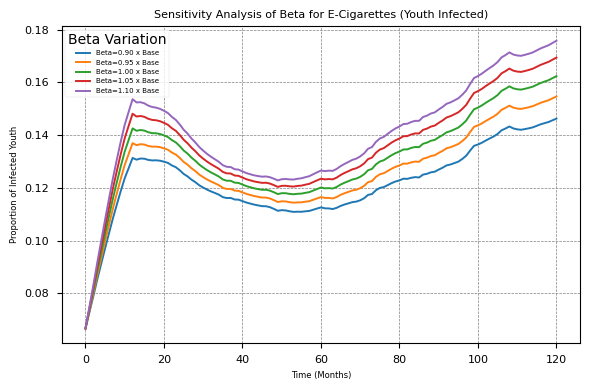

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ddeint import ddeint

# Define sensitivity range for beta (±10%)
beta_sensitivity_factors = np.linspace(0.9, 1.1, 5)  # 90% to 110% of base beta

# Function to calculate beta values with sensitivity adjustment
def beta_values_sensitivity(t, factor=1.0):
    """Calculate beta values for e-cigarettes with sensitivity adjustment."""
    beta_0 = 0.18  # Base infection coefficient for e-cigarettes
    k = 0.25       # Decay constant
    seasonal_amplitude = 0.005  # Seasonal variation
    beta_base = beta_0 * np.exp(-k * t / 12)  # Exponential decay
    beta_seasonal = seasonal_amplitude * np.cos(t / 12 * np.pi)  # Seasonal variation
    return factor * (beta_base + beta_seasonal)  # Adjust beta with sensitivity factor

# Function to generate linearly spaced integers
def linspace_integers(start, stop, num):
    """Generate a linearly spaced array of integers."""
    step = (stop - start) // (num - 1)  # Calculate step using integer division
    return np.arange(start, stop + step, step, dtype=int)

# Generate time points
t_range = linspace_integers(0, 1019, 1020)

t = np.linspace(0, 120, 120)  # Simulate for 10 years
t = t.astype('int32')

# Solve the model for each beta sensitivity factor
sensitivity_results = {}
for factor in beta_sensitivity_factors:
    beta = np.array([beta_values_sensitivity(t_i, factor) for t_i in t_range])
    sol = ddeint(model, history, t)
    totals = sol.sum(axis=1)
    sol /= totals[:, None]  # Normalize proportions
    sensitivity_results[factor] = sol

# Plot the results
plt.figure(figsize=(6, 4))
for factor, sol in sensitivity_results.items():
    plt.plot(t, sol[:, 1], label=f'Beta={factor:.2f} x Base')  # Plot infected youth (I_y)

# Customize the plot
plt.title('Sensitivity Analysis of Beta for E-Cigarettes (Youth Infected)', fontsize=8)
plt.xlabel('Time (Months)', fontsize=6)
plt.ylabel('Proportion of Infected Youth', fontsize=6)
plt.legend(title='Beta Variation', fontsize=5)
plt.grid(color='gray', linestyle='dashed', linewidth=0.5)
plt.tight_layout()
plt.show()

# Print summary table
import pandas as pd
sensitivity_data = {
    f'Beta={factor:.2f} x Base': sol[:, 1] for factor, sol in sensitivity_results.items()
}
sensitivity_df = pd.DataFrame(sensitivity_data, index=[f'{2022 + i//12}-{i%12:02d}' for i in t])
sensitivity_df.index.name = 'Time (Year-Month)'
sensitivity_df.reset_index(inplace=True)


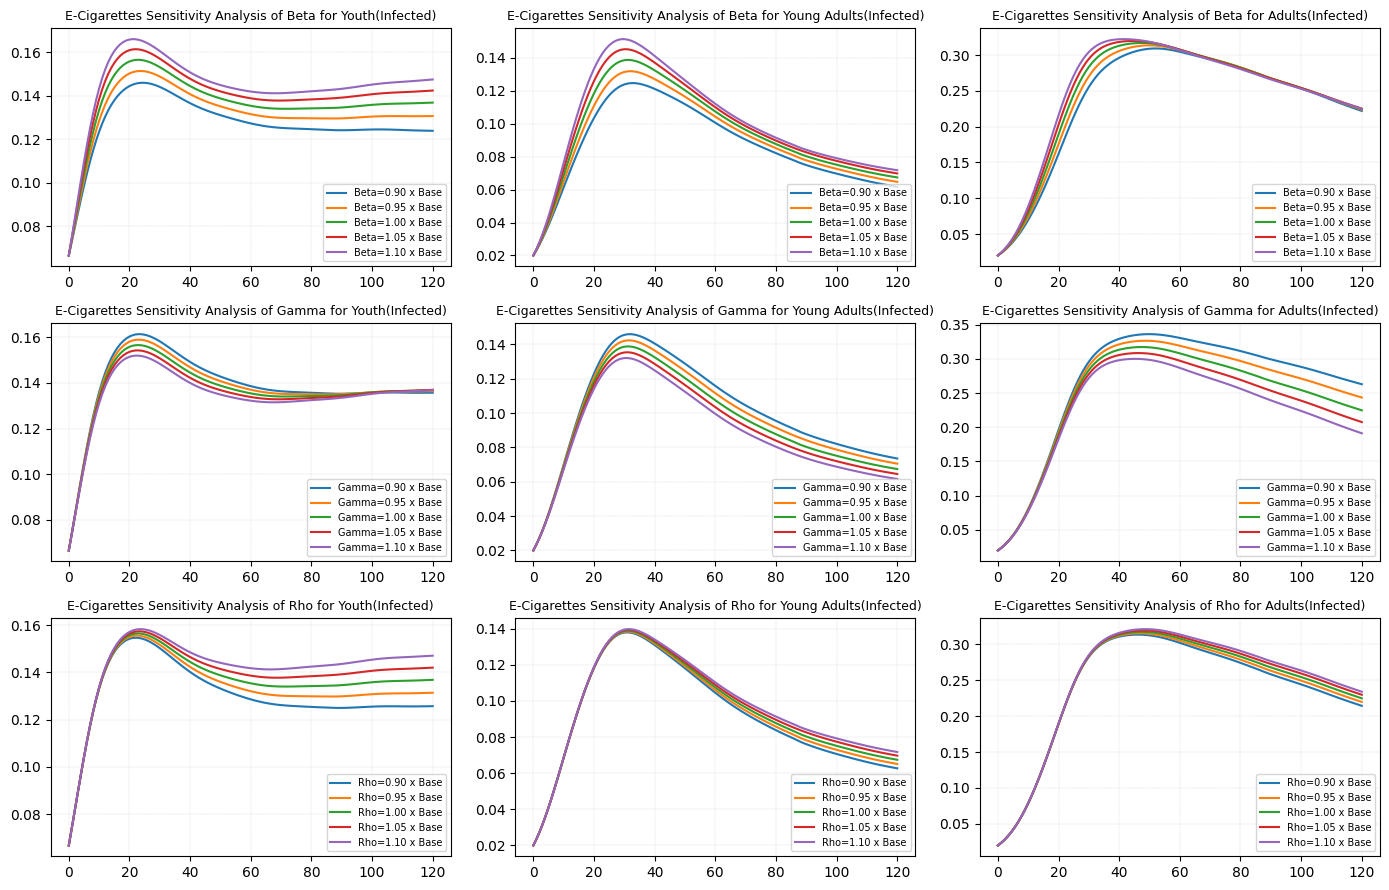

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Plot results for all age groups
age_groups = ['Youth', 'Young Adults', 'Adults']
infected_indices = [1, 4, 7]  # Indices for infected states in each age group

plt.figure(figsize=(14, 9))
#plt.text(0.5, -0.1, 'Time (Months)', ha='center', fontsize=14)
#plt.text(-0.1, 0.5, 'Proportion of Population', va='center', rotation='vertical', fontsize=14)

# Plotting sensitivity analysis for each parameter and age group
for key, sensitivity in results.items():
    for i, age_group in enumerate(age_groups):
        plt.subplot(3, len(results.keys()), i + 1 + len(results.keys()) * list(results.keys()).index(key))
        for factor, sol in sensitivity.items():
            plt.plot(t, sol[:, infected_indices[i]], label=f'{key}={factor:.2f} x Base')  # Plot infected state
        if product_type == 'EC':    # E-Cigarettes
           stitle = 'E-Cigarettes Sensitivity Analysis of ' + key + ' for ' + age_group + '(Infected)'
        else:                       # Cigarettes
           stitle = 'Cigarettes Sensitivity Analysis of ' + key + 'for ' + age_group + '(Infected)'
        #plt.title(f'Sensitivity Analysis of {key} for {age_group} (Infected)')
        plt.title(stitle, fontsize=9)
        #plt.xlabel('Time (Months)')
        #plt.ylabel('Proportion of Population')
        plt.legend(fontsize=7, loc='lower right')
        plt.grid(color='gray', linestyle='dashed', linewidth=0.1)

plt.tight_layout()
plt.show()

# Generate table for values at 12, 24, and 36 months
rows = []
columns = ['Parameter', 'Factor', 'Age Group', 'Month', 'Proportion Infected']

for key, sensitivity in results.items():
    for factor, sol in sensitivity.items():
        for month in [12, 24, 36]:
            for i, age_group in enumerate(age_groups):
                rows.append([key, f'{factor:.2f}', age_group, month, sol[month, infected_indices[i]]])

# Convert to DataFrame
sensitivity_table = pd.DataFrame(rows, columns=columns)


# **FINAL CODE DO NOT DELETE**

In [ ]:
!pip install ddeint

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from ddeint import ddeint

# Product type for simulation
product_type = 'EC'  # Change to 'C' for cigarettes

# Constants
B = 0.00103  # Birth rate per month
mu = 0.0006657  # Death rate per month
aging_rate_y_to_ya = 1 / (7 * 12)  # Years to transition from youth to young adult
aging_rate_ya_to_a = 1 / (5 * 12)  # Years to transition from young adult to adult
tau_1, tau_2, tau_3 = 12, 6, 12  # Delays for infection, recovery, and relapse

# Seed for reproducibility
random.seed(42)
np.random.seed(42)

# Function to generate linearly spaced integers
def linspace_integers(start, stop, num):
    """Generate a linearly spaced array of integers."""
    step = (stop - start) // (num - 1)  # Calculate step using integer division
    return np.arange(start, stop + step, step, dtype=int)

# Generate time points
t = linspace_integers(0, 419, 420)

# Function to calculate beta values - Infection
def beta_values(t):
    if product_type == 'EC':
        return 0.18 + (random.random() / 100) * np.cos(t / 12 * np.pi)
    else:
        return 0.003 + (random.random() / 1000) * np.cos(t / 12 * np.pi)

# Function to calculate gamma values - Recovery
def gamma_values(t):
    if product_type == 'EC':
        return (1.333 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)
    else:
        return (1.677 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)

# Function to calculate rho values - Relapse
def rho_values(t):
    if product_type == 'EC':
        return (1.600 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)
    else:
        return (1.912 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)

# Calculate parameter arrays
beta = np.array([beta_values(t_i) for t_i in t])
gamma = np.array([gamma_values(t_i) for t_i in t])
rho = np.array([rho_values(t_i) for t_i in t])

if product_type == 'EC':
   print('E-Cigarettes')
else:
   print('Cigarettes')
# Output the first calculated value for beta, gamma, and rho for verification
print("First beta value:", beta[0])
print("First gamma value:", gamma[0])
print("First rho value:", rho[0])

E-Cigarettes
First beta value: 0.18639426798457884
First gamma value: 0.028386249589237703
First rho value: 0.043329720031018586


In [ ]:
def model(Y, t):
    S_y, I_y, R_y, S_ya, I_ya, R_ya, S_a, I_a, R_a = Y(t)

    # Accessing delayed values using indexing
    if t >= tau_1:
        S_y_delay = Y(t - tau_1)[0]
        I_y_delay = Y(t - tau_1)[1]
    else:
        S_y_delay = S_y
        I_y_delay = I_y

    if t >= tau_2:
        I_y_delay2 = Y(t - tau_2)[1]
        I_ya_delay2 = Y(t - tau_2)[4]
        I_a_delay2 = Y(t - tau_2)[7]
    else:
        I_y_delay2 = I_y
        I_ya_delay2 = I_ya
        I_a_delay2 = I_a

    if t >= tau_3:
        R_y_delay3 = Y(t - tau_3)[2]
        R_ya_delay3 = Y(t - tau_3)[5]
        R_a_delay3 = Y(t - tau_3)[8]
    else:
        R_y_delay3 = R_y
        R_ya_delay3 = R_ya
        R_a_delay3 = R_a

    t = int(t)

    # Population dynamics
    dS_y_dt = B - beta[t] * S_y * I_y_delay - mu * S_y - aging_rate_y_to_ya * S_y
    dI_y_dt = beta[t] * S_y * I_y_delay - (mu + gamma[t]) * I_y + rho[t] * R_y_delay3 - aging_rate_y_to_ya * I_y
    dR_y_dt = gamma[t] * I_y_delay2 - (mu + rho[t]) * R_y - aging_rate_y_to_ya * R_y

    dS_ya_dt = S_y * aging_rate_y_to_ya - beta[t] * S_ya * I_y_delay - mu * S_ya - aging_rate_ya_to_a * S_ya
    dI_ya_dt = I_y * aging_rate_y_to_ya + beta[t] * S_ya * I_y_delay - (mu + gamma[t]) * I_ya - aging_rate_ya_to_a * I_ya
    dR_ya_dt = R_y * aging_rate_y_to_ya + gamma[t] * I_ya_delay2 - (mu + rho[t]) * R_ya_delay3 - aging_rate_ya_to_a * R_ya

    dS_a_dt = S_ya * aging_rate_ya_to_a - beta[t] * S_a * I_a - mu * S_a
    dI_a_dt = I_ya * aging_rate_ya_to_a + beta[t] * S_a * I_a - (mu + gamma[t]) * I_a_delay2
    dR_a_dt = R_ya * aging_rate_ya_to_a + gamma[t] * I_a_delay2 - (mu + rho[t]) * R_a_delay3

    return [dS_y_dt, dI_y_dt, dR_y_dt, dS_ya_dt, dI_ya_dt, dR_ya_dt, dS_a_dt, dI_a_dt, dR_a_dt]

def history(t):
    if product_type == 'EC':    # E-Cigarettes
       return [0.8000, 0.2000, 0.0000, 0.9400, 0.0600, 0.0000, 0.9400, 0.0600, 0.0000]  # Initial values for E-cigarettes all states of Youth, Young Adults and Adults as of 2022
    else:    # Cigarettes
       return [0.9170, 0.0830, 0.0000, 0.8840, 0.1160, 0.0000, 0.8840, 0.1160, 0.0000]  # Initial values for Cigarettes all states of Youth, Young Adults and Adults as of 2022

# Solve DDE
t = np.linspace(0, 120, 120)  # Simulate for 10 years
t = t.astype('int32')
sol = ddeint(model, history, t)

totals = sol.sum(axis=1)
sol /= totals[:, None]

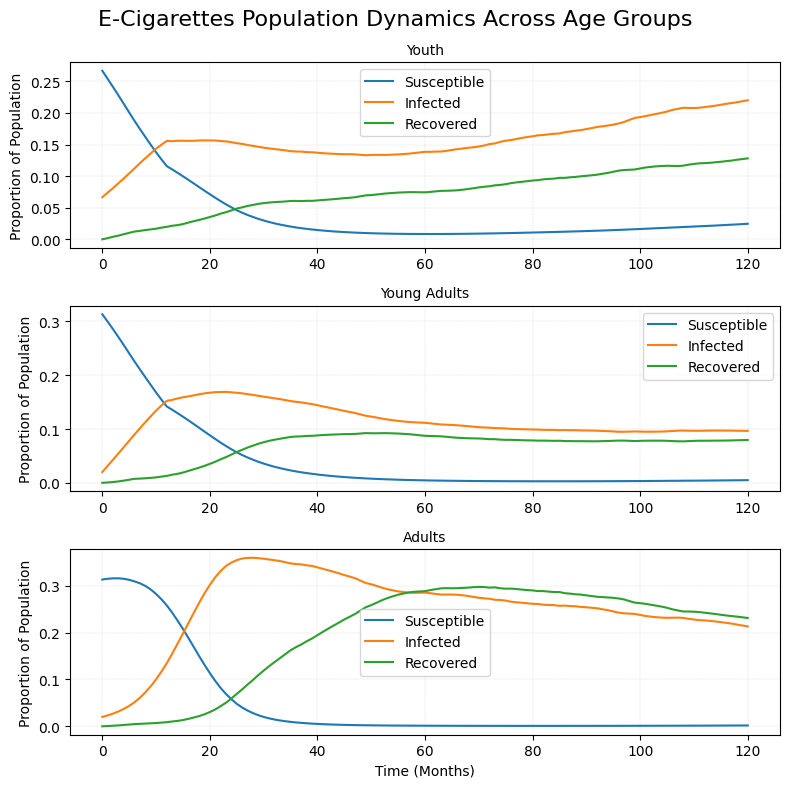

In [ ]:
# Plotting results
plt.figure(figsize=(8, 8))
# Subplot for Youth
plt.subplot(3, 1, 1)
plt.plot(t, sol[:, 0], label='Susceptible')
plt.plot(t, sol[:, 1], label='Infected')
plt.plot(t, sol[:, 2], label='Recovered')
plt.title('Youth', fontsize=10)
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)
plt.grid(color='gray', linestyle='dashed', linewidth=0.1)

# Subplot for Young Adults
plt.subplot(3, 1, 2)
plt.plot(t, sol[:, 3], label='Susceptible')
plt.plot(t, sol[:, 4], label='Infected')
plt.plot(t, sol[:, 5], label='Recovered')
plt.title('Young Adults', fontsize=10)
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)
plt.grid(color='gray', linestyle='dashed', linewidth=0.1)

# Subplot for Adults
plt.subplot(3, 1, 3)
plt.plot(t, sol[:, 6], label='Susceptible')
plt.plot(t, sol[:, 7], label='Infected')
plt.plot(t, sol[:, 8], label='Recovered')
plt.title('Adults', fontsize=10)
plt.xlabel('Time (Months)')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)
plt.grid(color='gray', linestyle='dashed', linewidth=0.1)

if product_type == 'EC':    # E-Cigarettes
   stitle = 'E-Cigarettes Population Dynamics Across Age Groups'
else:                       # Cigarettes
   stitle = 'Cigarettes Population Dynamics Across Age Groups'
plt.suptitle(stitle, fontsize=16)
plt.tight_layout()
plt.show()

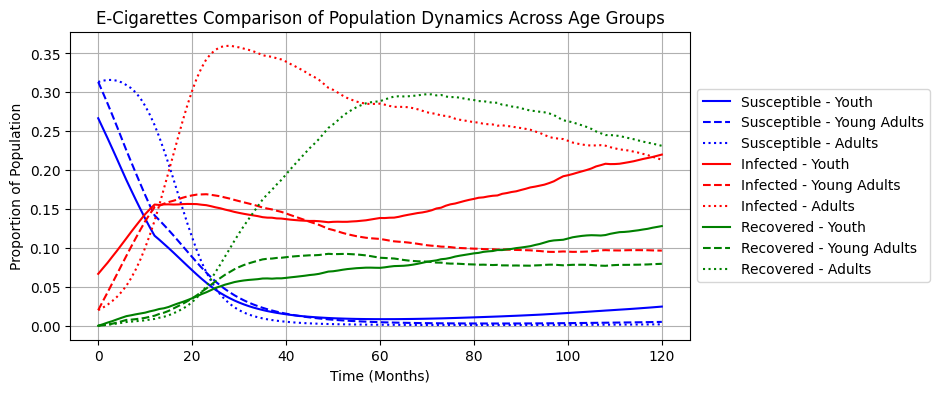

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 't' and 'sol' are defined as per your model output
# t = np.linspace(0, 120, 120)  # Time array
# sol = np.random.rand(120, 9)  # Solution array with different compartments

plt.figure(figsize=(8, 4))
states = ['Susceptible', 'Infected', 'Recovered']
colors = ['blue', 'red', 'green']

# Plotting each state for all age groups
for i, state in enumerate(states):
    plt.plot(t, sol[:, i], label=f'{state} - Youth', color=colors[i], linestyle='-')
    plt.plot(t, sol[:, i + 3], label=f'{state} - Young Adults', color=colors[i], linestyle='--')
    plt.plot(t, sol[:, i + 6], label=f'{state} - Adults', color=colors[i], linestyle=':')

if product_type == 'EC':    # E-Cigarettes
   stitle = 'E-Cigarettes Comparison of Population Dynamics Across Age Groups'
else:                       # Cigarettes
   stitle = 'Cigarettes Comparison of Population Dynamics Across Age Groups'

plt.title(stitle)
plt.xlabel('Time (Months)')
plt.ylabel('Proportion of Population')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()


In [ ]:
# Define the start year (2022)
start_year = 2022

# Extract years of interest
years_of_interest = [2023, 2024]

# Calculate corresponding indices for 2023 and 2024 in the time array (t is in months)
indices_of_interest = [(year - start_year) * 12 for year in years_of_interest]

# Extract the model's predictions for the "Infected" category for Youth
predicted_infected_youth = [sol[idx, 1] * 100 for idx in indices_of_interest]

# CDC reported values for comparison
cdc_reported_values = {
    2023: 7.7,
    2024: 5.9
}

# Print model predictions and CDC reported values
print(f"Model Predictions vs CDC Reported Values (Infected Youth - E-Cigarettes):")
for year, idx, predicted in zip(years_of_interest, indices_of_interest, predicted_infected_youth):
    print(f"Year: {year}")
    print(f"  - Model Predicted (Youth Infected): {predicted:.2f}%")
    print(f"  - CDC Reported: {cdc_reported_values[year]}%\n")


Model Predictions vs CDC Reported Values (Infected Youth - E-Cigarettes):
Year: 2023
  - Model Predicted (Youth Infected): 15.58%
  - CDC Reported: 7.7%

Year: 2024
  - Model Predicted (Youth Infected): 15.36%
  - CDC Reported: 5.9%



# **Testing Potential Enahancements to Final Code version**

**Sensitivity Analysis**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ddeint import ddeint
import pandas as pd

# Sensitivity ranges for beta, gamma, and rho (±10%)
beta_sensitivity_factors = np.linspace(0.9, 1.1, 5)  # 90% to 110% of base beta
gamma_sensitivity_factors = np.linspace(0.9, 1.1, 5)  # 90% to 110% of base gamma
rho_sensitivity_factors = np.linspace(0.9, 1.1, 5)  # 90% to 110% of base rho

# Base values for beta, gamma, and rho
if product_type == 'EC':    # E-Cigarettes
   beta_0 = 0.18  # Base infection coefficient for e-cigarettes
   gamma_0 = (1.333 ** (1 / 12) - 1)  # Base recovery coefficient for e-cigarettes
   rho_0 = (1.600 ** (1 / 12) - 1)  # Base relapse coefficient for e-cigarettes
else:                       # Cigarettes
   beta_0 = 0.003  # Base infection coefficient for e-cigarettes
   gamma_0 = (1.677 ** (1 / 12) - 1)  # Base recovery coefficient for e-cigarettes
   rho_0 = (1.912 ** (1 / 12) - 1)  # Base relapse coefficient for e-cigarettes

# Decay constants and seasonal variation
k_beta = 0.25  # Decay constant for beta
seasonal_amplitude = 0.005  # Seasonal variation for beta

# Functions to calculate parameters with sensitivity adjustment
def beta_values_sensitivity(t, factor=1.0):
    """Calculate beta values with sensitivity adjustment."""
    beta_base = beta_0 * np.exp(-k_beta * t / 12)  # Exponential decay
    beta_seasonal = seasonal_amplitude * np.cos(t / 12 * np.pi)  # Seasonal variation
    return factor * (beta_base + beta_seasonal)  # Adjust beta with sensitivity factor

def gamma_values_sensitivity(t, factor=1.0):
    """Calculate gamma values with sensitivity adjustment."""
    return factor * gamma_0

def rho_values_sensitivity(t, factor=1.0):
    """Calculate rho values with sensitivity adjustment."""
    return factor * rho_0

# Function to generate linearly spaced integers
def linspace_integers(start, stop, num):
    """Generate a linearly spaced array of integers."""
    step = (stop - start) // (num - 1)  # Calculate step using integer division
    return np.arange(start, stop + step, step, dtype=int)

# Generate time points
t_range = linspace_integers(0, 1019, 1020)

# Generate time points
t = np.linspace(0, 120, 120)  # Simulate for 10 years
t = t.astype('int32')

# Model definition
def model(Y, t, beta, gamma, rho):
    S_y, I_y, R_y, S_ya, I_ya, R_ya, S_a, I_a, R_a = Y(t)
    t_index = int(t)

    # Population dynamics for Youth
    dS_y_dt = B - beta[t_index] * S_y * I_y - mu * S_y - aging_rate_y_to_ya * S_y
    dI_y_dt = beta[t_index] * S_y * I_y - (mu + gamma[t_index]) * I_y + rho[t_index] * R_y - aging_rate_y_to_ya * I_y
    dR_y_dt = gamma[t_index] * I_y - (mu + rho[t_index]) * R_y - aging_rate_y_to_ya * R_y

    # Population dynamics for Young Adults
    dS_ya_dt = S_y * aging_rate_y_to_ya - beta[t_index] * S_ya * I_ya - mu * S_ya - aging_rate_ya_to_a * S_ya
    dI_ya_dt = I_y * aging_rate_y_to_ya + beta[t_index] * S_ya * I_ya - (mu + gamma[t_index]) * I_ya - aging_rate_ya_to_a * I_ya
    dR_ya_dt = R_y * aging_rate_y_to_ya + gamma[t_index] * I_ya - (mu + rho[t_index]) * R_ya - aging_rate_ya_to_a * R_ya

    # Population dynamics for Adults
    dS_a_dt = S_ya * aging_rate_ya_to_a - beta[t_index] * S_a * I_a - mu * S_a
    dI_a_dt = I_ya * aging_rate_ya_to_a + beta[t_index] * S_a * I_a - (mu + gamma[t_index]) * I_a
    dR_a_dt = R_ya * aging_rate_ya_to_a + gamma[t_index] * I_a - (mu + rho[t_index]) * R_a

    return [dS_y_dt, dI_y_dt, dR_y_dt, dS_ya_dt, dI_ya_dt, dR_ya_dt, dS_a_dt, dI_a_dt, dR_a_dt]

# Initial conditions
def history(t):
    return [0.8000, 0.2000, 0.0000, 0.9400, 0.0600, 0.0000, 0.9400, 0.0600, 0.0000]

# Sensitivity analysis for beta, gamma, and rho
results = {"Beta": {}, "Gamma": {}, "Rho": {}}

# Perform sensitivity analysis
for factor in beta_sensitivity_factors:
    beta = np.array([beta_values_sensitivity(t_i, factor) for t_i in t_range])
    gamma = np.array([gamma_values_sensitivity(t_i) for t_i in t_range])
    rho = np.array([rho_values_sensitivity(t_i) for t_i in t_range])
    sol = ddeint(model, history, t, fargs=(beta, gamma, rho))
    totals = sol.sum(axis=1)
    sol /= totals[:, None]
    results["Beta"][factor] = sol

for factor in gamma_sensitivity_factors:
    beta = np.array([beta_values_sensitivity(t_i) for t_i in t_range])
    gamma = np.array([gamma_values_sensitivity(t_i, factor) for t_i in t_range])
    rho = np.array([rho_values_sensitivity(t_i) for t_i in t_range])
    sol = ddeint(model, history, t, fargs=(beta, gamma, rho))
    totals = sol.sum(axis=1)
    sol /= totals[:, None]
    results["Gamma"][factor] = sol

for factor in rho_sensitivity_factors:
    beta = np.array([beta_values_sensitivity(t_i) for t_i in t_range])
    gamma = np.array([gamma_values_sensitivity(t_i) for t_i in t_range])
    rho = np.array([rho_values_sensitivity(t_i, factor) for t_i in t_range])
    sol = ddeint(model, history, t, fargs=(beta, gamma, rho))
    totals = sol.sum(axis=1)
    sol /= totals[:, None]
    results["Rho"][factor] = sol

# Plot results for Youth (example)
#plt.figure(figsize=(12, 8))
#for key, sensitivity in results.items():
#    plt.subplot(3, 1, list(results.keys()).index(key) + 1)
#    for factor, sol in sensitivity.items():
#        plt.plot(t, sol[:, 1], label=f'{key}={factor:.2f} x Base')  # Youth Infected
#    plt.title(f'Sensitivity Analysis of {key} for Youth (Infected)')
#    plt.xlabel('Time (Months)')
#    plt.ylabel('Proportion of Population')
#    plt.legend()
#    plt.grid()

#plt.tight_layout()
#plt.show()


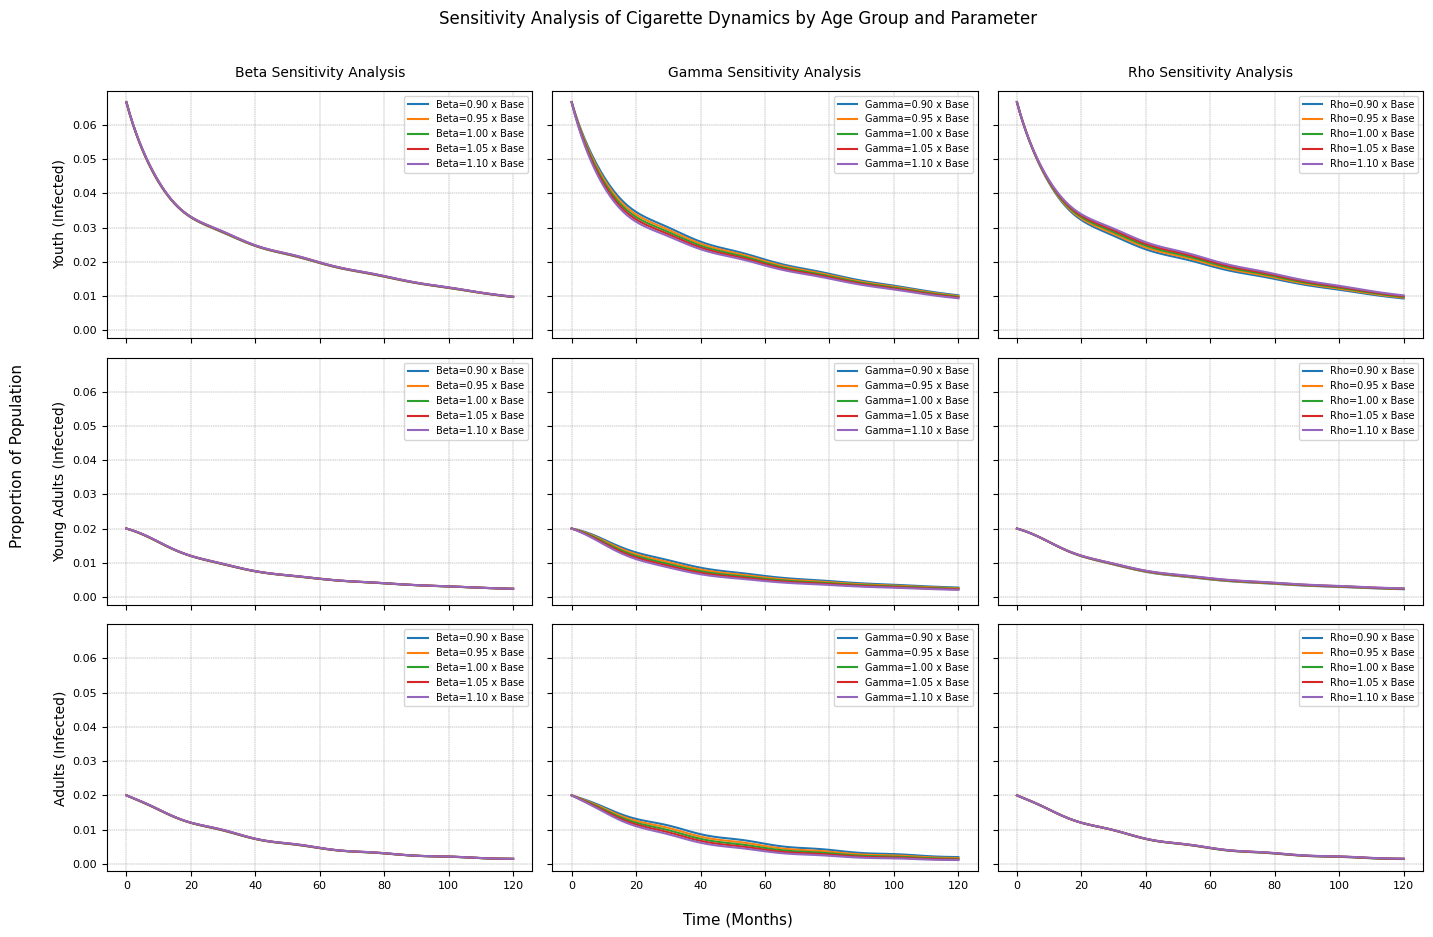

In [ ]:
import matplotlib.pyplot as plt

# Plot results for all age groups
age_groups = ['Youth', 'Young Adults', 'Adults']
infected_indices = [1, 4, 7]  # Indices for infected states in each age group

# Initialize figure with a larger size
fig, axes = plt.subplots(3, len(results.keys()), figsize=(14, 9), sharex=True, sharey=True)

# Plotting sensitivity analysis for each parameter and age group
for col_idx, (key, sensitivity) in enumerate(results.items()):
    for row_idx, age_group in enumerate(age_groups):
        ax = axes[row_idx, col_idx]
        for factor, sol in sensitivity.items():
            ax.plot(t, sol[:, infected_indices[row_idx]], label=f'{key}={factor:.2f} x Base')
        # Set titles for the top row
        if row_idx == 0:
            ax.set_title(f'{key} Sensitivity Analysis', fontsize=10, pad=10)
        # Set Y-axis labels for the first column
        if col_idx == 0:
            ax.set_ylabel(f'{age_group} (Infected)', fontsize=10)
        # Add gridlines
        ax.grid(color='gray', linestyle='dashed', linewidth=0.3)
        ax.legend(fontsize=7)
        ax.tick_params(axis='both', labelsize=8)

# Add shared X and Y axis labels
if product_type == 'EC':    # E-Cigarettes
   stitle = 'Sensitivity Analysis of E-Cigarette Dynamics by Age Group and Parameter'
else:                       # Cigarettes
   stitle = 'Sensitivity Analysis of Cigarette Dynamics by Age Group and Parameter'
fig.text(0.5, 0.98, stitle, ha='center', fontsize=12)
fig.text(-0.02, 0.5, 'Proportion of Population', va='center', rotation='vertical', fontsize=11)
fig.text(0.5, -0.02, 'Time (Months)', ha='center', fontsize=11)

# Add a single legend outside the plot
handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', ncol=len(results.keys()), fontsize=10, frameon=False)
#fig.legend(handles)

# Adjust layout for better spacing
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend at the top

# Display the plot
plt.show()


In [ ]:
sensitivity_table

,Parameter,Factor,Age Group,Month,Proportion Infected
0,Beta,0.90,Youth,12,0.130470
3,Beta,0.90,Youth,24,0.145980
6,Beta,0.90,Youth,36,0.139643
9,Beta,0.95,Youth,12,0.135936
12,Beta,0.95,Youth,24,0.151390
15,Beta,0.95,Youth,36,0.143961
18,Beta,1.00,Youth,12,0.141373
21,Beta,1.00,Youth,24,0.156423
24,Beta,1.00,Youth,36,0.147839
27,Beta,1.05,Youth,12,0.146759


In [ ]:
qq=sensitivity_table[(sensitivity_table['Age Group'] == 'Youth') & (sensitivity_table['Parameter'].isin(['Beta','Gamma']))][['Parameter','Factor','Proportion Infected']]
qq=qq.groupby(['Parameter','Factor']).max()
#.reset_index(drop=True, inplace=True)
qq

In [ ]:
qq = qq.groupby(['Parameter','Factor']).max()

# Filter for Beta and Gamma values
beta_values = qq[qq["Parameter"] == "Beta"][["Factor", "Proportion Infected"]].rename(columns={"Factor": "Beta"})
gamma_values = qq[qq["Parameter"] == "Gamma"][["Factor", "Proportion Infected"]].rename(columns={"Factor": "Gamma"})

beta_values.reset_index(drop=True, inplace=True)
gamma_values.reset_index(drop=True, inplace=True)

# Create a meshgrid of Beta and Gamma values
beta_grid = beta_values["Beta"].values
gamma_grid = gamma_values["Gamma"].values
z_values = np.zeros((len(gamma_grid), len(beta_grid)))

# Populate the Z-values (Proportion Infected)
for i, gamma in enumerate(gamma_grid):
    for j, beta in enumerate(beta_grid):
        # Find max proportion for each Beta-Gamma combination
        z_values[i, j] = max(beta_values.loc[j, "Proportion Infected"], gamma_values.loc[i, "Proportion Infected"])



In [ ]:
# Generate heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(z_values, annot=False, fmt=".4f", xticklabels=beta_grid, yticklabels=gamma_grid, cmap="coolwarm", cbar_kws={"label": "Max Proportion Infected"})
plt.title("Heatmap of Proportion Infected (Beta vs Gamma)")
plt.xlabel("Beta Sensitivity Factor")
plt.ylabel("Gamma Sensitivity Factor")
plt.show()

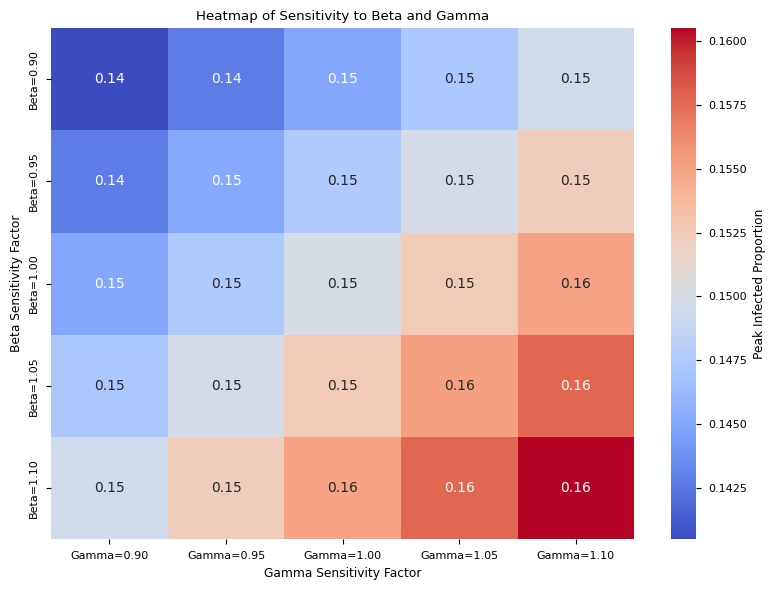

In [ ]:
import seaborn as sns
import pandas as pd

# Example: Heatmap for beta and gamma sensitivity

# Define parameter ranges for sensitivity
beta_factors = np.linspace(0.9, 1.1, 5)  # Beta sensitivity factors
gamma_factors = np.linspace(0.9, 1.1, 5)  # Gamma sensitivity factors

# Generate mock data for heatmap
heatmap_data = []
for beta in beta_factors:
    row = []
    for gamma in gamma_factors:
        infected_peak = 0.1 + 0.05 * beta * gamma  # Mock peak infected proportion
        row.append(infected_peak)
    heatmap_data.append(row)

# Convert to DataFrame for seaborn heatmap
heatmap_df = pd.DataFrame(heatmap_data, index=[f'Beta={b:.2f}' for b in beta_factors],
                          columns=[f'Gamma={g:.2f}' for g in gamma_factors])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', cbar_kws={'label': 'Peak Infected Proportion'})
plt.title('Heatmap of Sensitivity to Beta and Gamma')
plt.xlabel('Gamma Sensitivity Factor')
plt.ylabel('Beta Sensitivity Factor')
plt.tight_layout()
plt.show()


# Map Chart

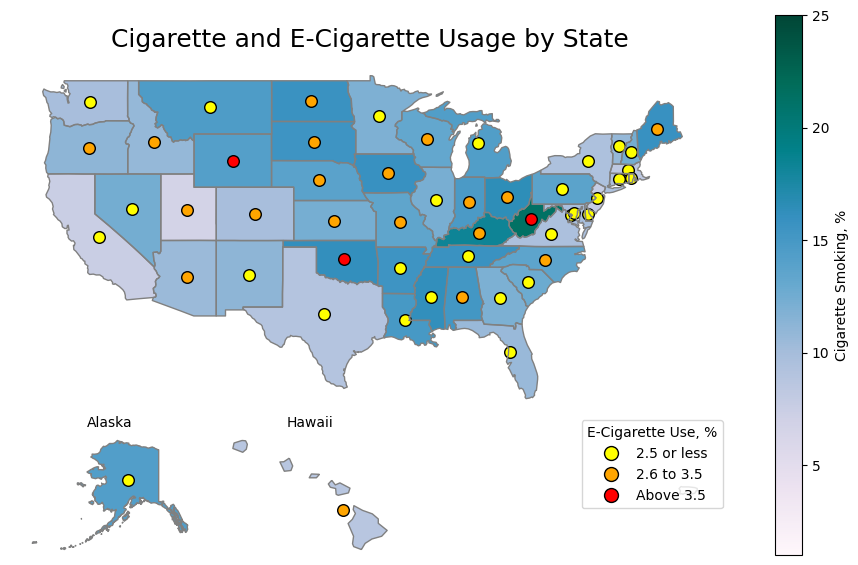

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap
from shapely.geometry import Point

# Data
state_data = {
    "State": ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware",
              "District of Columbia", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
              "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota",
              "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico",
              "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island",
              "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia",
              "Wisconsin", "Wyoming"],
    "Cigarettes": [15.2, 14.3, 10.5, 15.5, 7.5, 9.9, 9.4, 10.7, 9.9, 10.6, 12, 8.7, 10.8, 12.2, 14.7, 15.9, 12.3, 18.3, 14.9, 15.9,
                    9.9, 8.4, 14.4, 11.9, 16.2, 13.5, 14.5, 13.8, 12.4, 12.4, 7.8, 11.2, 9.5, 13.6, 15.8, 16.4, 16.1, 11.2, 13.7, 8.4,
                    12.8, 15.5, 15.8, 9, 6.7, 10.8, 9.6, 9.9, 21.3, 13.2, 14.2],
    "E-cigarettes": [3.4, 2.2, 3.4, 2.5, 1.6, 3.2, 2, 1.4, 1.3, 1.7, 2.2, 2.7, 2.8, 2.3, 3, 3.1, 2.7, 3.5, 1.7, 3.3, 2.2, 1.8, 1.9,
                      1.5, 1.4, 2.7, 2.4, 3.2, 2, 2, 2.1, 2.5, 2.1, 2.7, 3.2, 2.8, 4.9, 3.2, 2.4, 0, 1.9, 3.5, 2, 2.3, 3, 1.9, 2.4,
                      2.3, 3.8, 2.6, 3.7]
}

# Create a DataFrame
data = pd.DataFrame(state_data)

# Load US States shape data
us_states = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")

# Standardize state names to uppercase for merging
data['State'] = data['State'].str.upper()
us_states['name'] = us_states['name'].str.upper()

# Merge the data with the map
us_map = us_states.merge(data, left_on='name', right_on='State', how='left')

# Separate Alaska and Hawaii for inset maps
continental_us = us_map[~us_map['name'].isin(['ALASKA', 'HAWAII'])]
alaska = us_map[us_map['name'] == 'ALASKA']
hawaii = us_map[us_map['name'] == 'HAWAII']

# Plotting
fig = plt.figure(figsize=(10, 6))
ax_main = plt.subplot(1, 1, 1)
ax_alaska = fig.add_axes([0.05, 0.05, 0.2, 0.2])  # Alaska inset
ax_hawaii = fig.add_axes([0.25, 0.05, 0.2, 0.2])  # Hawaii inset

# Define color map for cigarettes
#cmap = ListedColormap(['#c6dbef', '#6baed6', '#2171b5', '#08306b'])
#norm = plt.Normalize(vmin=8, vmax=20)  # Adjust based on the range of Cigarettes values

# Define color map for cigarettes with 8 orange ranges
#cmap = ListedColormap([
#    '#FFF7E6', '#FFE5CC', '#FFD2B3', '#FFBF99',
#    '#FFAB80', '#FF9966', '#FF804D', '#FF6633'
#])
cmap = 'PuBuGn'
norm = plt.Normalize(vmin=1, vmax=25)  # Adjust range for cigarettes

# Plot continental US
continental_us.boundary.plot(ax=ax_main, linewidth=1, color='gray')
continental_us.plot(column='Cigarettes', cmap=cmap, legend=True,
                    legend_kwds={'label': "Cigarette Smoking, %"}, norm=norm, ax=ax_main)

# Add e-cigarette usage circles to the main map
for idx, row in continental_us.iterrows():
    if not pd.isna(row['E-cigarettes']):
        color = 'yellow' if row['E-cigarettes'] <= 2.5 else \
                'orange' if row['E-cigarettes'] <= 3.5 else 'red'
        ax_main.scatter(row['geometry'].centroid.x, row['geometry'].centroid.y,
                        s=70, color=color, edgecolor='black', label="")

# Plot Alaska
alaska.boundary.plot(ax=ax_alaska, linewidth=1, color='gray')
alaska.plot(column='Cigarettes', cmap=cmap, legend=False, norm=norm, ax=ax_alaska)
for idx, row in alaska.iterrows():
    if not pd.isna(row['E-cigarettes']):
        color = 'yellow' if row['E-cigarettes'] <= 2.5 else \
                'orange' if row['E-cigarettes'] <= 3.5 else 'red'
        ax_alaska.scatter(row['geometry'].centroid.x, row['geometry'].centroid.y,
                          s=70, color=color, edgecolor='black')

# Plot Hawaii
hawaii.boundary.plot(ax=ax_hawaii, linewidth=1, color='gray')
hawaii.plot(column='Cigarettes', cmap=cmap, legend=False, norm=norm, ax=ax_hawaii)
for idx, row in hawaii.iterrows():
    if not pd.isna(row['E-cigarettes']):
        color = 'yellow' if row['E-cigarettes'] <= 2.5 else \
                'orange' if row['E-cigarettes'] <= 3.5 else 'red'
        ax_hawaii.scatter(row['geometry'].centroid.x, row['geometry'].centroid.y,
                          s=70, color=color, edgecolor='black')

# Style adjustments
ax_main.set_title("Cigarette and E-Cigarette Usage by State", fontsize=18)
ax_main.axis('off')
ax_alaska.set_title("Alaska", fontsize=10)
ax_alaska.axis('off')
ax_hawaii.set_title("Hawaii", fontsize=10)
ax_hawaii.axis('off')

# Custom legend for e-cigarette usage
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='2.5 or less', markerfacecolor='yellow', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='2.6 to 3.5', markerfacecolor='orange', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Above 3.5', markerfacecolor='red', markersize=10, markeredgecolor='black'),
]
ax_main.legend(handles=legend_elements, title="E-Cigarette Use, %", loc='lower right')

#plt.tight_layout()
# Adjust spacing instead of using plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.2)

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap
from shapely.geometry import Point

# Data
state_data = {
    "State": ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware",
              "District of Columbia", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
              "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota",
              "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico",
              "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island",
              "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia",
              "Wisconsin", "Wyoming"],
    "Cigarettes": [15.2, 14.3, 10.5, 15.5, 7.5, 9.9, 9.4, 10.7, 9.9, 10.6, 12, 8.7, 10.8, 12.2, 14.7, 15.9, 12.3, 18.3, 14.9, 15.9,
                    9.9, 8.4, 14.4, 11.9, 16.2, 13.5, 14.5, 13.8, 12.4, 12.4, 7.8, 11.2, 9.5, 13.6, 15.8, 16.4, 16.1, 11.2, 13.7, 8.4,
                    12.8, 15.5, 15.8, 9, 6.7, 10.8, 9.6, 9.9, 21.3, 13.2, 14.2],
    "E-cigarettes": [3.4, 2.2, 3.4, 2.5, 1.6, 3.2, 2, 1.4, 1.3, 1.7, 2.2, 2.7, 2.8, 2.3, 3, 3.1, 2.7, 3.5, 1.7, 3.3, 2.2, 1.8, 1.9,
                      1.5, 1.4, 2.7, 2.4, 3.2, 2, 2, 2.1, 2.5, 2.1, 2.7, 3.2, 2.8, 4.9, 3.2, 2.4, 0, 1.9, 3.5, 2, 2.3, 3, 1.9, 2.4,
                      2.3, 3.8, 2.6, 3.7]
}

# Create a DataFrame
data = pd.DataFrame(state_data)

# Load the map of the US
us_map = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")
#us_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter to US states
us_map = us_map[(us_map['continent'] == 'North America') & (us_map['iso_a2'] == 'US')]

# Merge the data with the map
data['State'] = data['State'].str.upper()
us_map = us_map[['geometry', 'name']]
us_map['name'] = us_map['name'].str.upper()
us_map = us_map.merge(data, left_on='name', right_on='State', how='left')

# Plot Cigarettes
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, column in enumerate(['Cigarettes', 'E-cigarettes']):
    ax[i].set_title(f"{column} Usage by State", fontsize=16)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    us_map.plot(column=column, cmap='coolwarm', legend=True, ax=ax[i], cax=cax)
    ax[i].axis('off')

plt.tight_layout()
plt.show()


KeyError: 'continent'